In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import xarray as xr

import dask

In [2]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

# **Water Permamency**


Import required DC utils

In [3]:
import datacube
# DC utilities
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.import_export import export_xarray_to_netcdf
from datacube_utilities.createAOI import create_lat_lon
from datacube.storage import masking
from datacube_utilities.clean_mask import lee_filter

Define aoi via wkt polygon (could be subbed or shapefile)

In [4]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
#testarea
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
aoi_wkt = "POLYGON((177.34673877691375 -17.587272740290974,177.6955546948825 -17.587272740290974,177.6955546948825 -17.800529711996226,177.34673877691375 -17.800529711996226,177.34673877691375 -17.587272740290974))"
#whole country
aoi_wkt = "POLYGON((177.34096527101 -17.746353149414, 177.43160247804 -17.744293212891, 177.4364089966 -17.834930419922, 177.34165191652 -17.833557128906, 177.34096527101 -17.746353149414))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [5]:
#set baseline start and end of period
start_date = '2019-1-1'
end_date = '2019-12-1'
res = (30)

In [6]:
dc = datacube.Datacube(app="water permamency")

In [7]:
dask_chunks=dict(
    x=1000,
    y=1000
)

In [8]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [9]:
display_map(latitude = lat_extents, longitude = lon_extents)

In [10]:
#create resolution
resolution = (-res, res)

In [11]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(start_date, end_date)

### Load Data

Generic query specs

In [12]:
query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = baseline_time_period,
                resolution = resolution,
                group_by = 'solar_day',
                dask_chunks = dask_chunks
            )


Dataset-specifics

In [13]:
dsL8 = dc.load(product='ls8_water_classification',
               measurements = ["water"],
               **query)

In [14]:
dsL7 = dc.load(product='ls7_water_classification',
                measurements = ["water"],
               **query)

In [15]:
dsL5 = dc.load(product='ls5_water_classification',
                measurements = ["water"],
               **query)

In [16]:
dsL4 = dc.load(product='ls4_water_classification',
                measurements = ["water"],
               **query)

In [17]:
dsS1 = dc.load(product='s1g_gamma0_scene',
              **query)

In [18]:

def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [19]:
waterL8 = dsL8.where(dsL8 != -9999)
waterL7 = dsL7.where(dsL7 != -9999)
waterL5 = dsL5.where(dsL5 != -9999)
waterL4 = dsL4.where(dsL4 != -9999)

In [20]:
dsS2 = dc.load(product='s2_esa_sr_granule',
               platform = 'SENTINEL_2',
                  measurements = ["blue", "green","red","nir","swir1","swir2", "scene_classification"],
                  **query)

In [21]:
def createS1water (ds_s1):
    #s1_coverage = masking.mask_invalid_data(ds)
    #s1_coverage_clean = s1_coverage.where(s1_coverage!=0)
    # save the nodata mask as Lee filter doesn't consider nan
    #nodata_mask = s1_coverage_clean.isnull().to_array().any(axis=0)
    #replace nan with 0
    #ds_s1_filled = s1_coverage.where(~s1_coverage.isnull(), 0)
    ds_s1_filled = ds_s1.where(~ds_s1.isnull(), 0)
    
    ds_s1["filtered_vv"] = ds_s1_filled.vv.groupby("time").apply(lee_filter, size=7)
    ds_s1["filtered_vh"] = ds_s1_filled.vh.groupby("time").apply(lee_filter, size=7)
    #smoothed=smoothed.where(~nodata_mask)
    #clean=smoothed.copy()
    #clean['vv'] =clean.vv.where(~clean.vv.isnull(), 1000)
    #clean['vh'] =clean.vh.where(~clean.vh.isnull(), 1000)
    #clean['vv'] =clean.vv.where(clean.vv>0, 1e-3)
    #clean['vh'] =clean.vh.where(clean.vh>0, 1e-4)
    #clean=clean.where(clean<1000)
    vv_threshold = 12
    vh_threshold = -20.0
    ds_s1['water'] = ((ds_s1["filtered_vv"] <= vv_threshold) & (ds_s1["filtered_vh"] <= vh_threshold))
    ds_s1_ready = xr.Dataset.drop(ds_s1, labels = ["vh", "vv", "layovershadow_mask"])
    #s1_water = s1_coverage['water']
    return ds_s1_ready

In [22]:
from datacube.storage import masking
from datacube_utilities.clean_mask import lee_filter
if is_dataset_empty(dsS1):
    print('no S1 images for this time and area')
else:
    s1water = dask.delayed(createS1water(dsS1))
    s1water_comp = s1water.compute()
    

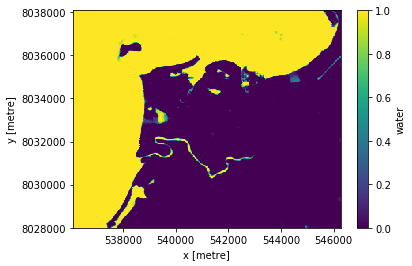

In [23]:
s1water_comp.water.mean(dim = 'time').plot();

In [24]:
#s1_coverage.wofs.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)

In [25]:
if is_dataset_empty(dsS2):
    print('invalid')
else:
    good_quality = (
            (dsS2.scene_classification != 0) & # mask out NO_DATA
            (dsS2.scene_classification != 1) & # mask out SATURATED_OR_DEFECTIVE
            (dsS2.scene_classification != 2) & # mask out DARK_AREA_PIXELS
            (dsS2.scene_classification != 3) & # mask out CLOUD_SHADOWS
            (dsS2.scene_classification != 8) & # mask out CLOUD_MEDIUM_PROBABILITY
            (dsS2.scene_classification != 9) & # mask out CLOUD_HIGH_PROBABILITY
            (dsS2.scene_classification != 10)&  # mask out THIN_CIRRUS
            (dsS2.scene_classification != 11)  # mask out SNOW
        )
    water_classes = dask.delayed(wofs_classify)(dsS2, clean_mask=good_quality.values, no_data = np.nan , x_coord='x', y_coord = "y")
    waterS2 = dask.delayed(water_classes.rename({'wofs': 'water'}))
    waterS2_comp = waterS2.compute()
    

In [26]:
waterL8_comp = waterL8.compute()
waterL7_comp = waterL7.compute()
waterL5_comp = waterL5.compute()
waterL4_comp = waterL4.compute()

In [27]:
merged = xr.Dataset.merge(waterL4_comp, waterL8_comp, waterL7_comp, waterL5_comp)

In [28]:
if is_dataset_empty(dsS2):
    print('stick with L8 only merge')
else:
    merged = xr.Dataset.merge(waterS2_comp, merged)

In [29]:
if is_dataset_empty(dsS1):
    print('stick with L8/S2 only merge')
else:
    merged = xr.Dataset.merge(s1water_comp, merged)

In [30]:
water_composite_mean = merged.water.mean(dim='time')

In [31]:
print(merged)

<xarray.Dataset>
Dimensions:      (time: 194, x: 339, y: 336)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-02T22:30:09 ... 2019-11-30T06:40:08
  * y            (y) float64 8.038e+06 8.038e+06 ... 8.028e+06 8.028e+06
  * x            (x) float64 5.361e+05 5.361e+05 ... 5.462e+05 5.463e+05
Data variables:
    filtered_vv  (time, y, x) float32 nan nan nan ... -9.270599 -8.732429
    filtered_vh  (time, y, x) float32 nan nan nan ... -15.31893 -15.03446
    water        (time, y, x) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes:
    crs:      EPSG:32760


Visualise wofs summary product

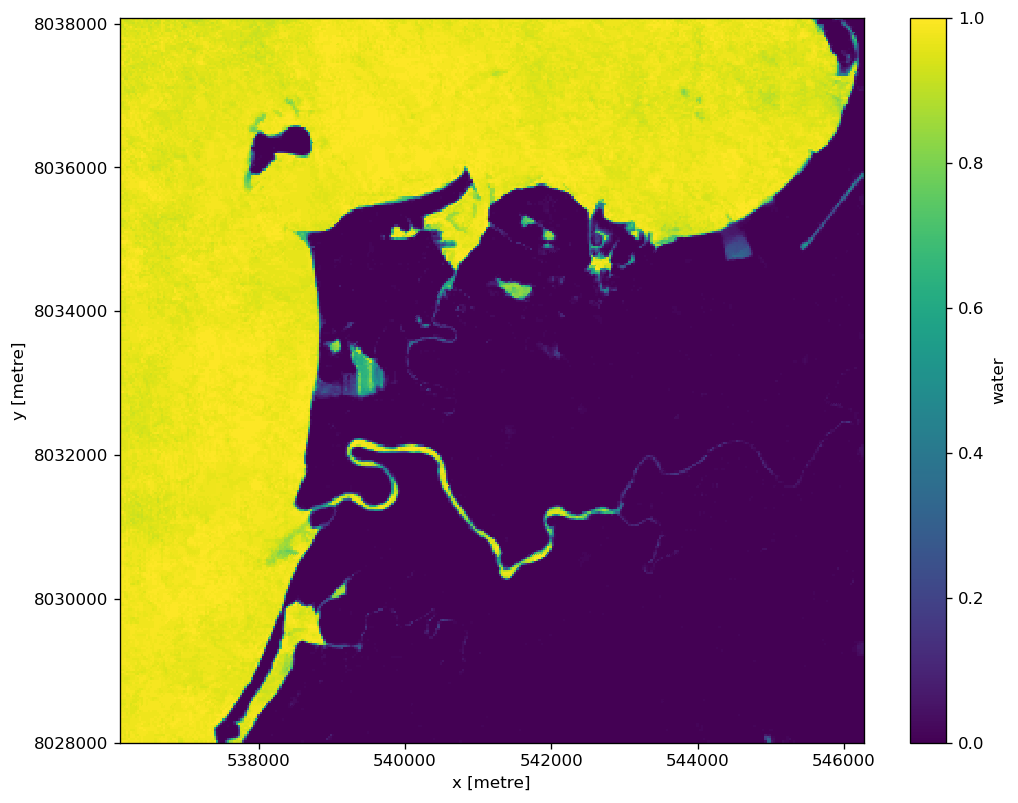

In [32]:
plt.figure(figsize = (10,8), dpi=120)
merged.water.mean(dim = 'time').plot();

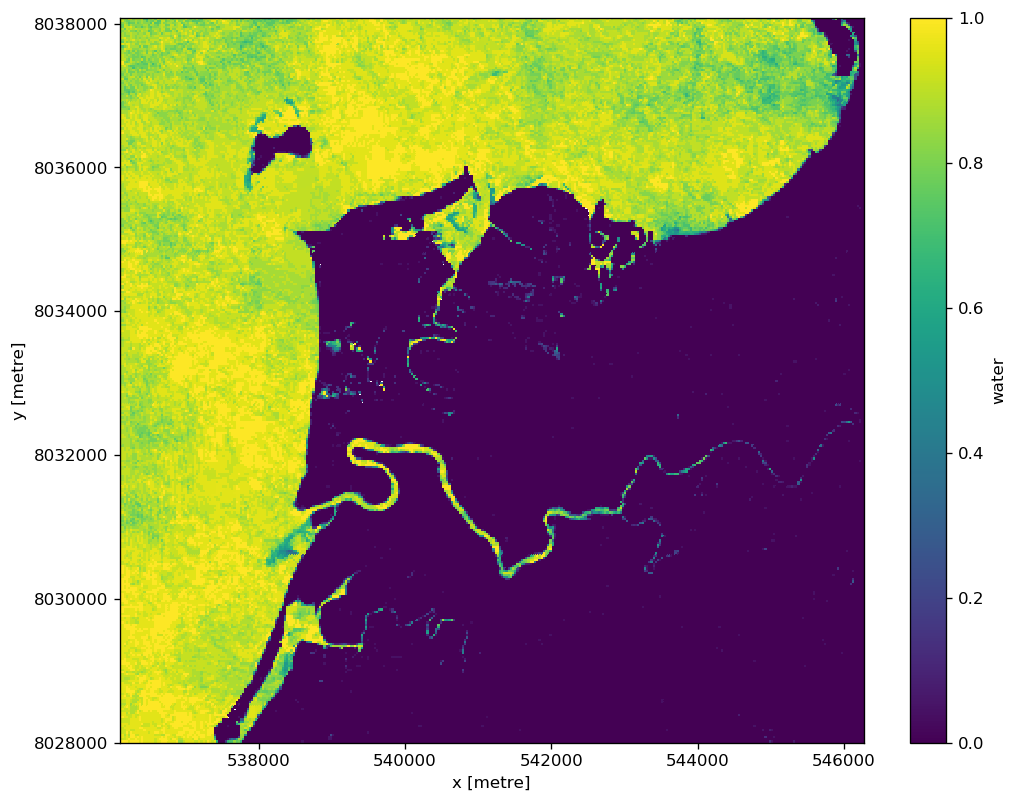

In [33]:
plt.figure(figsize = (10,8), dpi=120)
waterS2_comp.water.mean(dim = 'time').plot();

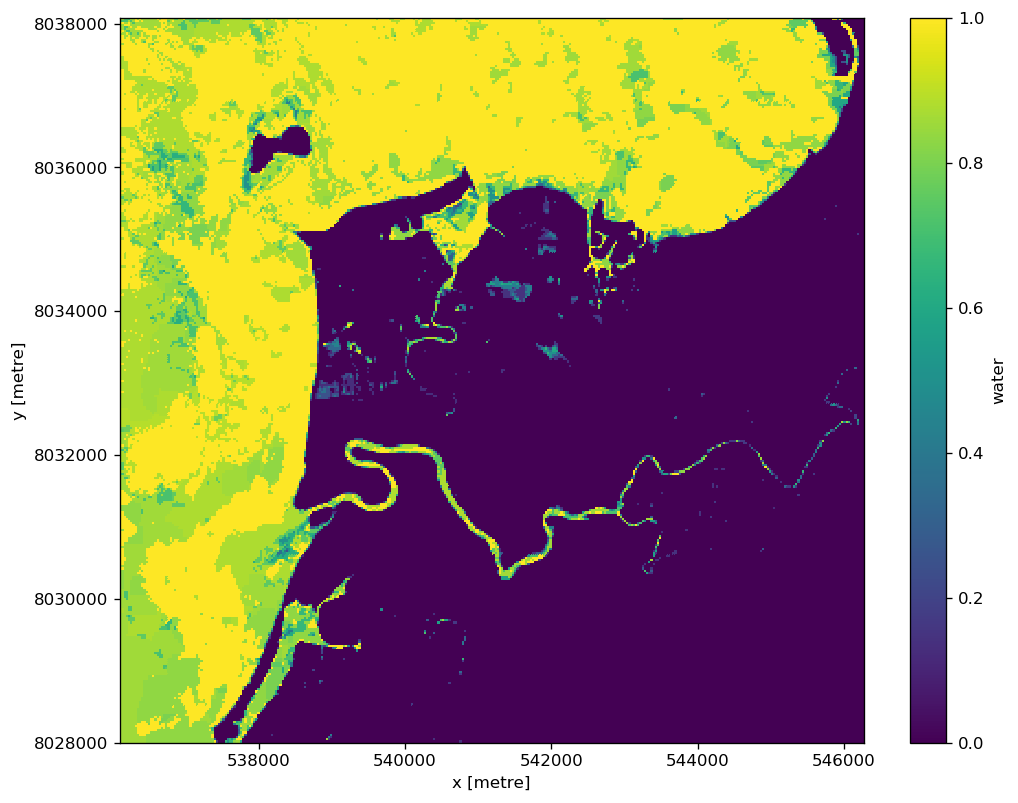

In [34]:
plt.figure(figsize = (10,8), dpi=120)
waterL8_comp.water.mean(dim = 'time').plot();

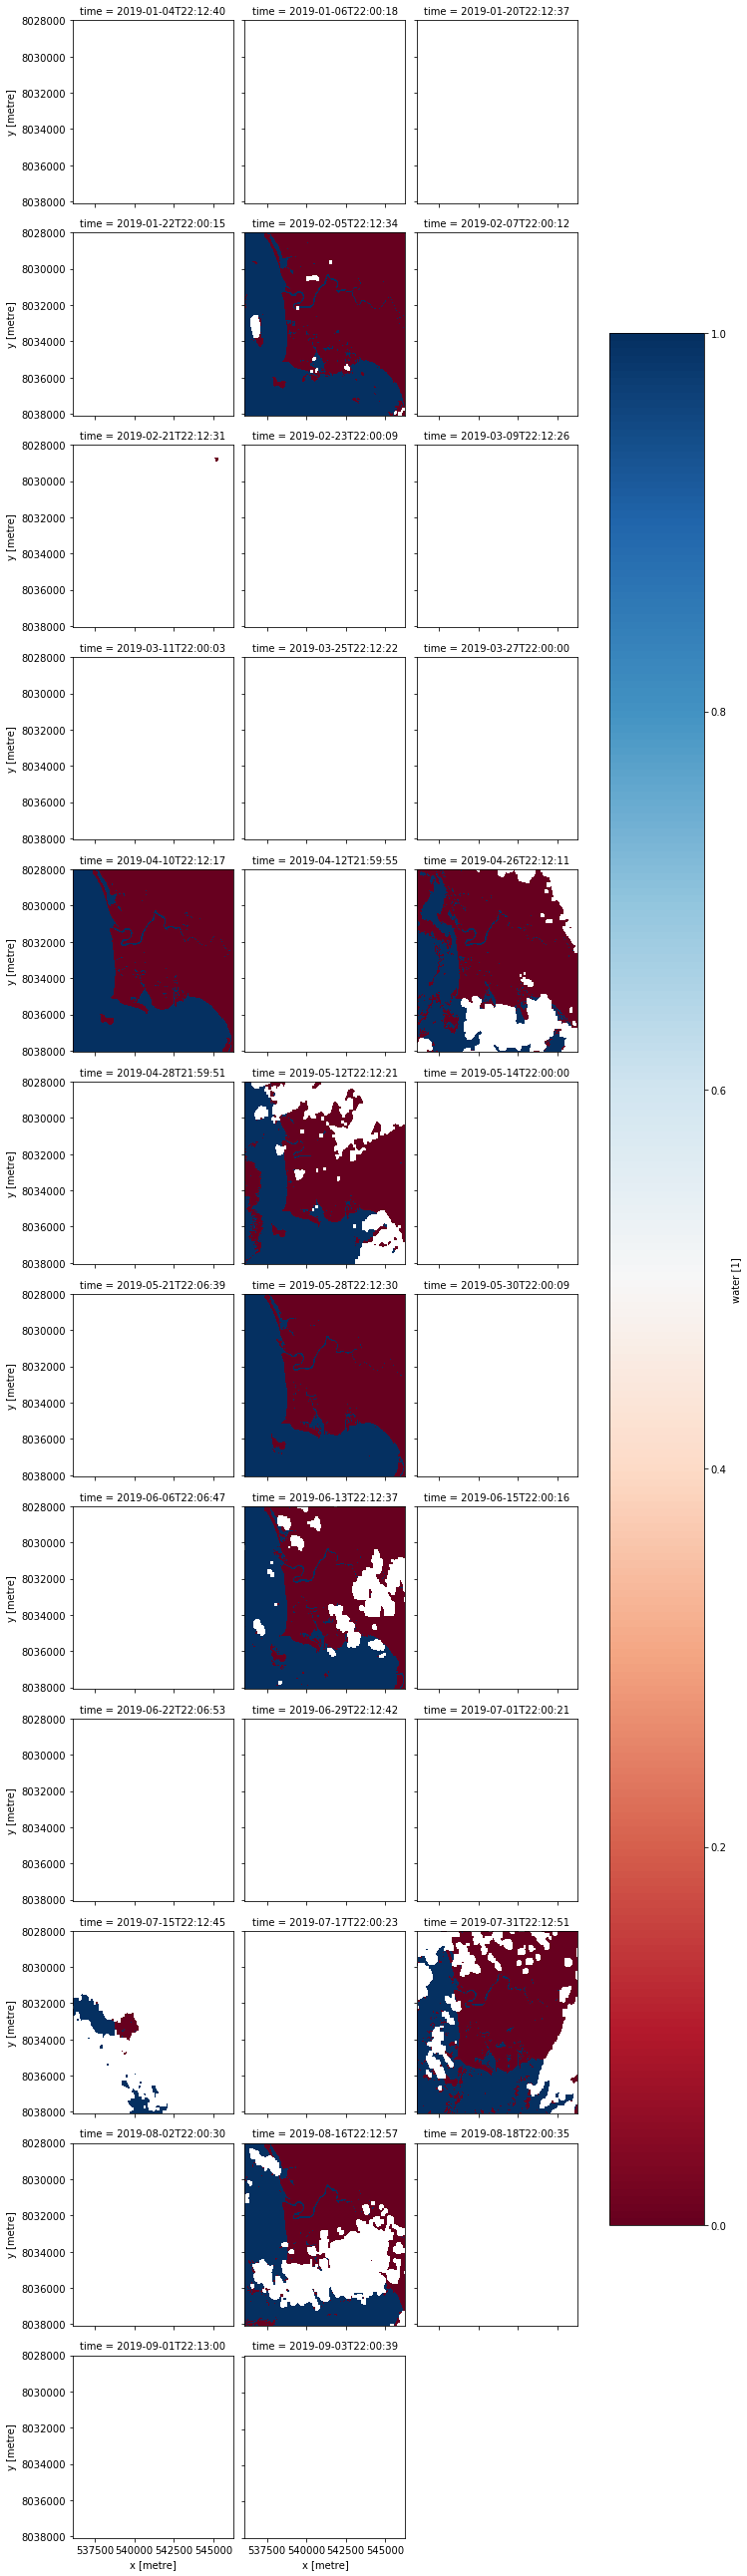

In [35]:
waterL8_comp.water.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)

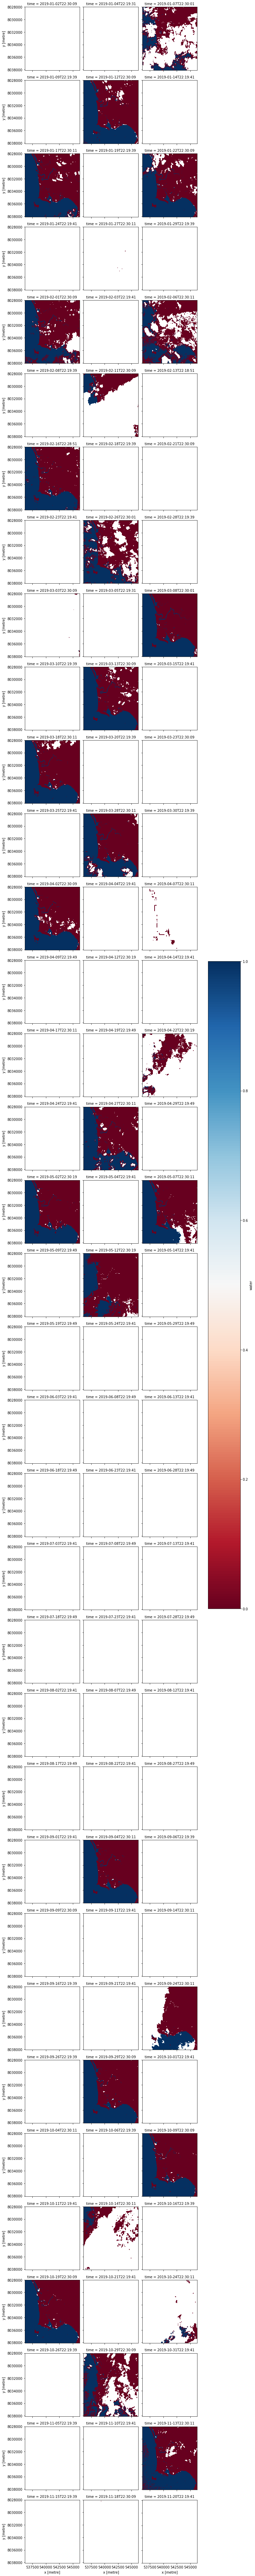

In [36]:
waterS2_comp.water.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)